<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_PyTorchTraining/blob/main/IG_ImageProcessingPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# torchvision - dataset, models architectures and image transformation
# torchvision.dataset
# torchvision.models
# torchvision.transformers
# torchvision.utils.data.DataLoaders

In [2]:
# base package
import torch
# neural network package
from torch import nn
# torchvision from image processing
import torchvision
# to load dataset from torchvision
from torchvision import datasets
# to perform transform and augmentation
from torchvision.transforms import ToTensor
# to plot images data
import matplotlib.pyplot as plt

In [3]:
train_data = datasets.FashionMNIST(
    root="dataset", # location where data will be downloaded
    train = True, # to download training data
    download = True, # download data if it doesn't exists
    transform = ToTensor(), # convert images into Torch tensor
    target_transform = None
    )

test_data = datasets.FashionMNIST(
    root="dataset", # location where data will be downloaded
    train = False, # to download training data
    download = True, # download data if it doesn't exists
    transform = ToTensor(), # convert images into Torch tensor
    )

100%|██████████| 26421880/26421880 [00:02<00:00, 12565879.83it/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207815.19it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3921990.07it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10165855.46it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [8]:
img, label = train_data[0]

In [9]:
label

9

In [10]:
img.shape

torch.Size([1, 28, 28])

In [11]:
# [color_channel, height, width]
# [1,28,28]

In [12]:
len(train_data.data)

60000

In [13]:
len(test_data.data)

10000

In [14]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

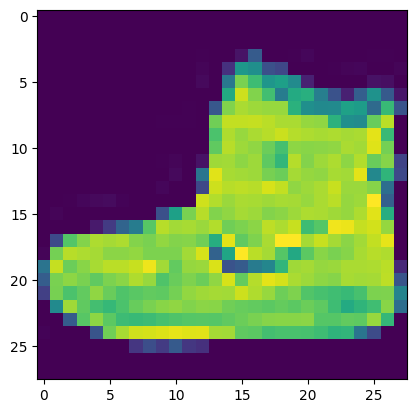

In [16]:
plt.imshow(img.squeeze())
plt.show()

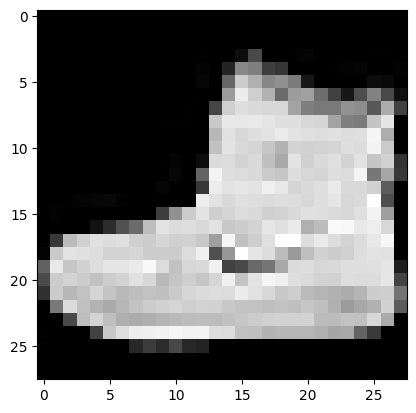

In [17]:
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [18]:
img.shape

torch.Size([1, 28, 28])

In [19]:
img.squeeze().shape

torch.Size([28, 28])